## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

print_config()

MONAI version: 1.3.dev2339
Numpy version: 1.23.5
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: dd091ba781289a362ad3f97a91a24d97ac044a39
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or U

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\jothi\AppData\Local\Temp\tmpty2fersv


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [04:37, 5.80MB/s]                               

2023-10-30 23:13:21,641 - INFO - Downloaded: C:\Users\jothi\AppData\Local\Temp\tmpty2fersv\Task09_Spleen.tar


2023-10-30 23:13:23,982 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-10-30 23:13:23,983 - INFO - Writing into directory: C:\Users\jothi\AppData\Local\Temp\tmpty2fersv.


## Set MSD Spleen dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


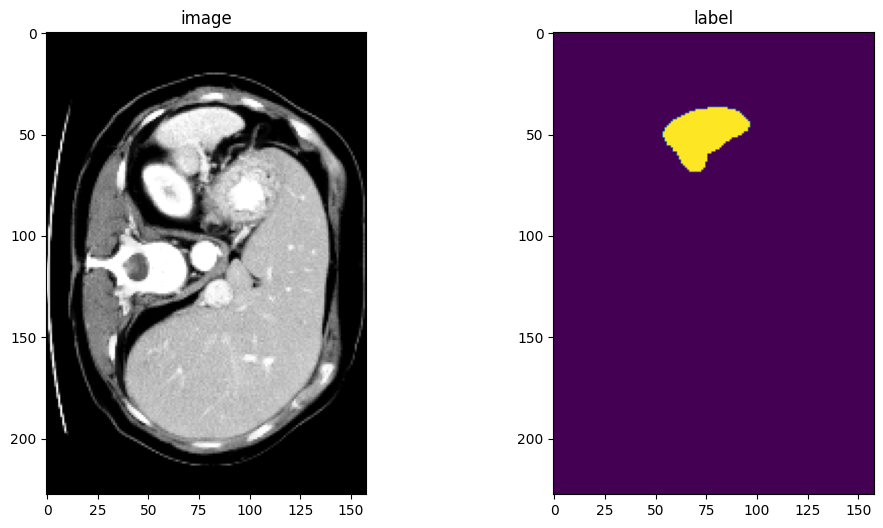

In [12]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [13]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


## Create Model, Loss, Optimizer

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [15]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"],
            batch_data["label"]
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_dice_coefficients = []  # List to store Dice coefficients for this validation epoch
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"],
                    val_data["label"]
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                val_dice_coefficients.append(dice_metric.aggregate().item())
                # Calculate and display the mean Dice coefficient for this validation epoch
                mean_dice_coefficient = np.mean(val_dice_coefficients)
                print(
                    f"current epoch: {epoch + 1} current mean dice: {mean_dice_coefficient:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
                    )

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "D:/Jodi/Sem7/medical/project/model"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/16, train_loss: 0.6651
2/16, train_loss: 0.6767
3/16, train_loss: 0.6719
4/16, train_loss: 0.6672
5/16, train_loss: 0.6558
6/16, train_loss: 0.6718
7/16, train_loss: 0.6490
8/16, train_loss: 0.6678
9/16, train_loss: 0.6570
10/16, train_loss: 0.6407
11/16, train_loss: 0.6569
12/16, train_loss: 0.6306
13/16, train_loss: 0.6527
14/16, train_loss: 0.6563
15/16, train_loss: 0.6550
16/16, train_loss: 0.6274
epoch 1 average loss: 0.6564
----------
epoch 2/600
1/16, train_loss: 0.6029
2/16, train_loss: 0.6502
3/16, train_loss: 0.6467
4/16, train_loss: 0.6381
5/16, train_loss: 0.6559
6/16, train_loss: 0.6137
7/16, train_loss: 0.6227
8/16, train_loss: 0.6287
9/16, train_loss: 0.6207
10/16, train_loss: 0.6021
11/16, train_loss: 0.6428
12/16, train_loss: 0.6312
13/16, train_loss: 0.6528
14/16, train_loss: 0.6205
15/16, train_loss: 0.6406
16/16, train_loss: 0.6166
epoch 2 average loss: 0.6304
current epoch: 2 current mean dice: 0.0166
best mean dice: -1.0000 at epoch: -1
cu

In [16]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9542 at epoch: 576


## Plot the loss and metric

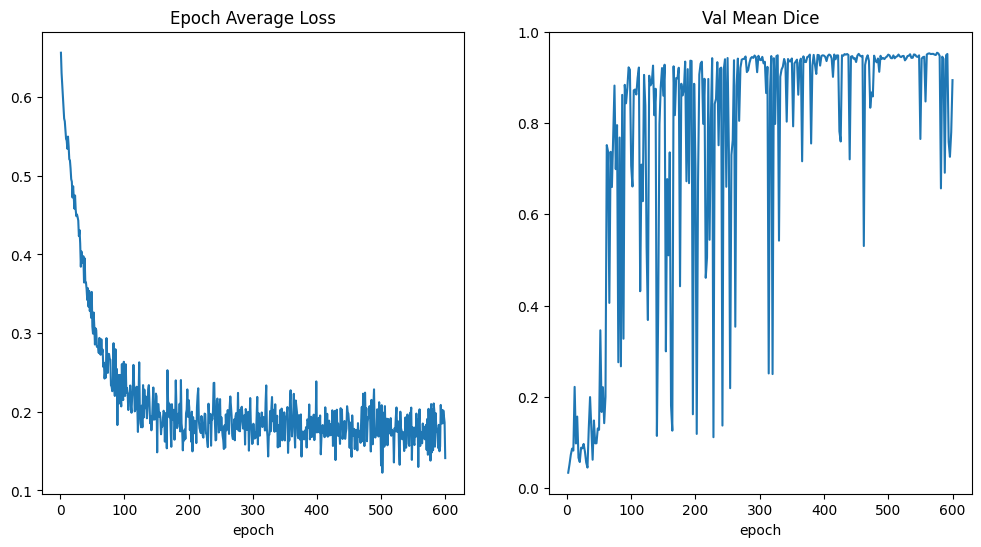

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

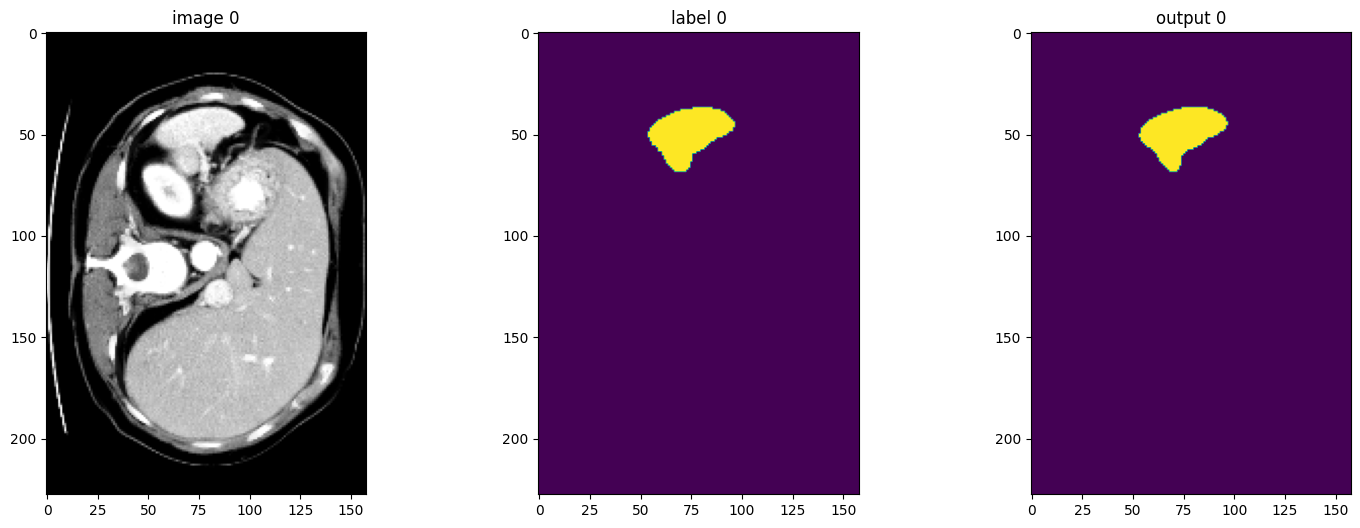

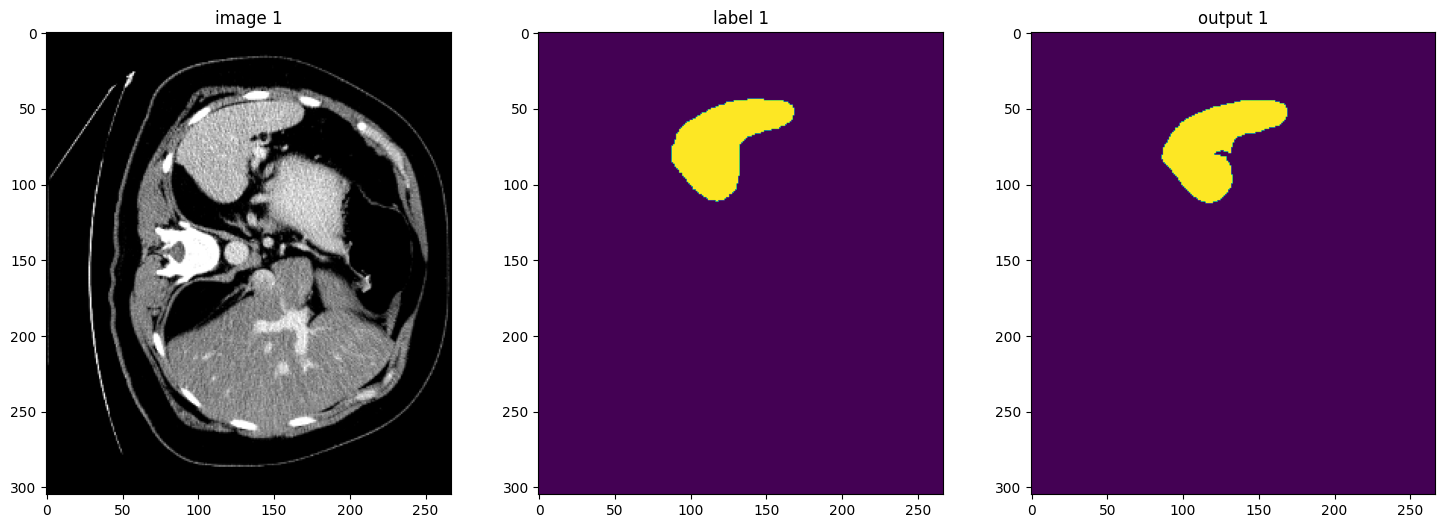

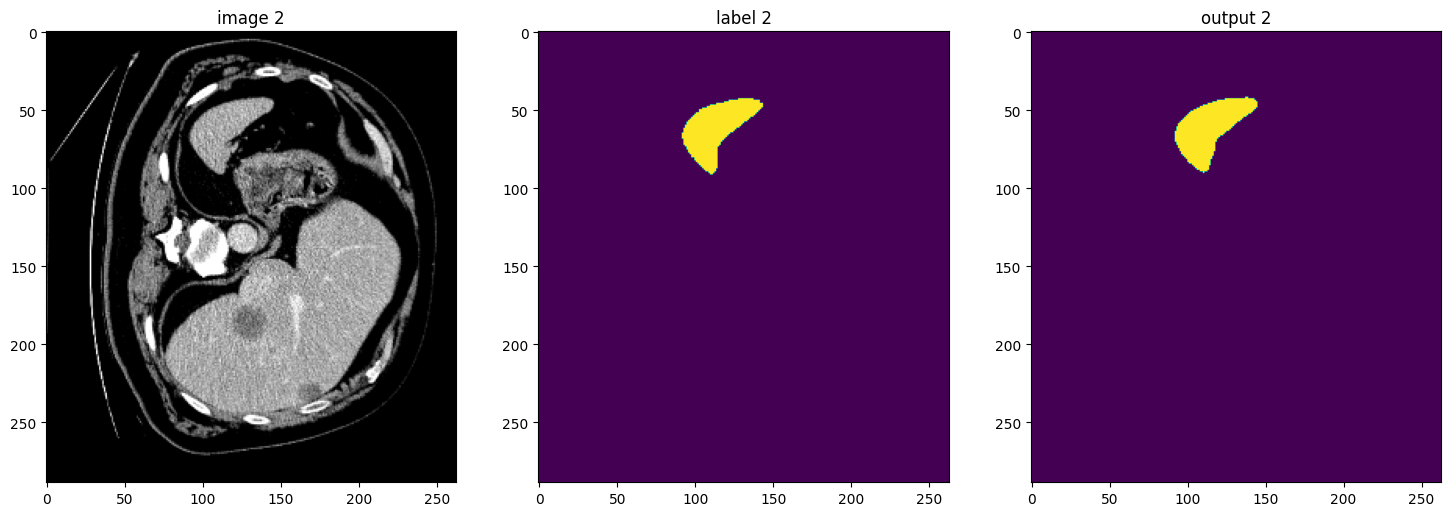

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "D:/Jodi/Sem7/medical/project/model")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"], roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Cleanup data directory

Remove directory if a temporary was used.

In [5]:
if directory is None:
    shutil.rmtree(root_dir)

## Error Analysis

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def calculate_dice_coefficient(prediction, ground_truth):
    intersection = np.logical_and(prediction, ground_truth).sum()
    dice = (2.0 * intersection) / (prediction.sum() + ground_truth.sum())
    return dice


In [21]:
# Assuming you have already loaded and set up your model and data

# Set the model in evaluation mode
model.eval()


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [22]:
dice_scores = []

In [23]:
print(dice_scores)

[]


In [24]:
for val_data in val_loader:
    val_inputs, val_labels = val_data["image"], val_data["label"]

In [25]:
with torch.no_grad():
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]


In [26]:
 # Calculate Dice coefficient for each validation sample
for i in range(len(val_outputs)):
        predicted_seg = val_outputs[i].cpu().numpy()
        ground_truth_seg = val_labels[i].cpu().numpy()
        dice = calculate_dice_coefficient(predicted_seg, ground_truth_seg)
        dice_scores.append(dice)


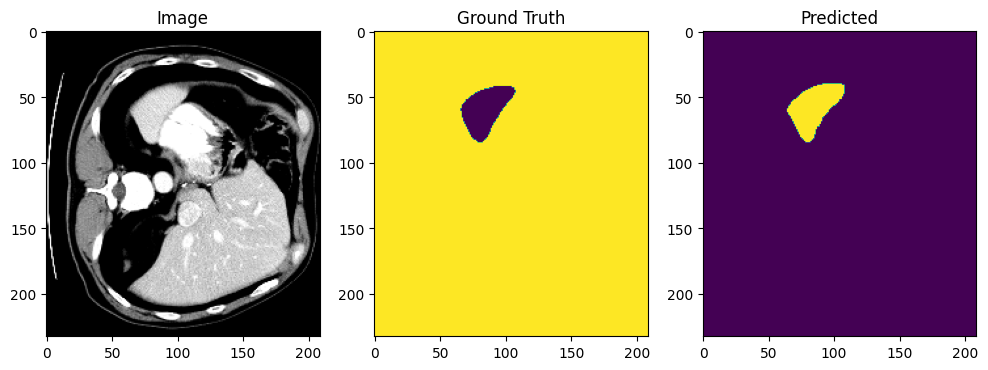

In [32]:
 # Visualize segmentation errors for cases with low Dice coefficients
if dice < 1:
    plt.figure("Segmentation Error", (12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(val_data["image"][i, 0, :, :, 80], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_seg[0, :, :, 80])
    plt.subplot(1, 3, 3)
    plt.title("Predicted")
    plt.imshow(predicted_seg[1, :, :, 80])
    plt.show()


In [31]:
# Calculate the overall Dice coefficient for the dataset
mean_dice = np.mean(dice_scores)
print(f"Mean Dice coefficient: {mean_dice:.4f}")

Mean Dice coefficient: 0.9991
